**Simple Neural Audio Codec with Residual Vector Quantization (RVQ)**

**Project Description**: This notebook implements a lightweight neural audio compression model using PyTorch. It demonstrates the core components of modern neural codecs (like EnCodec or SoundStream) by building:

**Convolutional Encoder**: Compresses raw audio into a compact latent representation.

**Residual Vector Quantizer (RVQ)**: Discretizes the latent space using multiple codebooks to achieve high-fidelity compression.

**Convolutional Decoder**: Reconstructs the audio waveform from the quantized codes.

**Multi-Scale STFT Loss**: Optimizes the model by comparing frequency-domain characteristics of the original and reconstructed audio.


In [2]:
!pip install torch torchaudio

**Configuration and Data Preparation**:

This block sets up the environment and prepares the data for training. It performs the following steps:

**Imports**: Loads necessary libraries like soundfile for reading audio, numpy for array manipulation, and torch for tensor operations.

**Configuration**: Defines key settings, such as the target_sr (16kHz), which determines the quality and sampling rate of the audio processing.

**Audio Loading**: Reads the input audio file, converts it to mono (single channel), resamples it to the target rate if necessary, and normalizes the volume to ensure consistent input levels.

**Batching Helper**: Defines a get_batch function to format the audio data correctly for the neural network.

In [13]:
import torch
import soundfile as sf
import numpy as np
from scipy.signal import resample_poly
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

wav_path = "/content/INPUT.wav"
target_sr = 16000

wav, sr = sf.read(wav_path, dtype="float32")

if wav.ndim == 2:
    wav = wav.mean(axis=1)

if sr != target_sr:
    wav = resample_poly(wav, target_sr, sr)
    sr = target_sr

wav = torch.from_numpy(wav).unsqueeze(0)  # [1, T]

# normalize
wav = wav / (wav.abs().max() + 1e-8)

total_len = wav.size(1)
batch_size = 1

def get_batch(wav, batch_size=1):
    return wav  # [1, T]

x = get_batch(wav, batch_size)
print(x.shape)  # [1, T], full waveform


torch.Size([1, 214358])


**Neural Encoder Network**

This cell defines the Encoder class, a convolutional neural network. Its primary job is downsampling. It takes the high-resolution raw audio waveform and passes it through a series of 1D convolutional layers with striding. This reduces the temporal dimension of the audio by a factor of 128 (e.g., compressing 16,000 samples into 125 latent vectors), creating a dense, low-resolution representation of the sound.

In [14]:
class Encoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, stride=2, padding=3),   # T / 2
            nn.ReLU(),

            nn.Conv1d(16, 32, kernel_size=7, stride=4, padding=3), # T / 8
            nn.ReLU(),

            nn.Conv1d(32, 48, kernel_size=7, stride=4, padding=3), # T / 32
            nn.ReLU(),

            nn.Conv1d(48, 64, kernel_size=7, stride=4, padding=3), # T / 128
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

B, T = 4, 16384
x = torch.randn(B, 1, T)

encoder = Encoder()
z = encoder(x)

print(z.shape)


torch.Size([4, 64, 128])


**Residual Vector Quantizer (RVQ)**

This cell implements the RVQ module, which is the heart of the compression mechanism. It takes the continuous output from the Encoder and maps it to discrete codes from a "codebook."

**Residual Logic**: It uses multiple codebooks in a sequence. The first codebook approximates the signal, and subsequent codebooks attempt to capture the error (residual) left behind by the previous ones. This hierarchical approach allows the model to capture fine details efficiently.

**Straight-Through Estimator**: It uses a mathematical trick to allow gradients to flow through the non-differentiable quantization step during backpropagation.

In [15]:
class RVQ(nn.Module):

    def __init__(
        self,
        dim: int,
        num_codebooks: int = 8,
        codebook_size: int = 512
    ):
        super().__init__()
        self.num_codebooks = num_codebooks
        self.codebook_size = codebook_size

        self.codebooks = nn.ModuleList([
            nn.Embedding(codebook_size, dim)
            for _ in range(num_codebooks)
        ])

        for cb in self.codebooks:
            nn.init.uniform_(cb.weight, -1.0 / dim, 1.0 / dim)

    def forward(self, x):
        # x: [B, D, T]
        x = x.permute(0, 2, 1)   # [B, T, D]

        residual = x
        quantized = torch.zeros_like(x)
        all_tokens = []

        for cb in self.codebooks:
            # distances: [B, T, K]
            dist = (
                residual.pow(2).sum(dim=-1, keepdim=True)
                - 2 * residual @ cb.weight.t()
                + cb.weight.pow(2).sum(dim=-1)
            )

            tokens = dist.argmin(dim=-1)          # [B, T]
            embed = cb(tokens)                    # [B, T, D]

            quantized = quantized + embed
            residual = residual - embed

            all_tokens.append(tokens)

        tokens = torch.stack(all_tokens, dim=-1)  # [B, T, num_codebooks]

        # straight-through estimator
        quantized = x + (quantized - x).detach()

        return quantized.permute(0, 2, 1), tokens


# -------------------------------
# Sanity check
# -------------------------------
B, D, T = 2, 64, 128
z = torch.randn(B, D, T)

rvq = RVQ(dim=D, num_codebooks=8, codebook_size=512)
q, tokens = rvq(z)

print(q.shape)       # [B, 64, T]
print(tokens.shape)  # [B, T, 8]


torch.Size([2, 64, 128])
torch.Size([2, 128, 8])


**Neural Decoder Network**

This cell defines the Decoder class, which reverses the Encoder's process. It performs upsampling. Taking the compressed, quantized vectors as input, it uses layers of nearest-neighbor interpolation followed by convolutions to expand the data back to the original sample rate. The final layer uses a tanh activation function to ensure the output audio waveform stays within the standard numerical range of [-1, 1].

In [16]:
class Decoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(64, 48, kernel_size=7, padding=3)
        self.conv2 = nn.Conv1d(48, 32, kernel_size=7, padding=3)
        self.conv3 = nn.Conv1d(32, 16, kernel_size=7, padding=3)
        self.conv4 = nn.Conv1d(16, 1,  kernel_size=7, padding=3)

    def forward(self, x):
        # x: [B, 64, T/128]

        x = F.interpolate(x, scale_factor=4, mode="nearest")  # T/32
        x = F.relu(self.conv1(x))

        x = F.interpolate(x, scale_factor=4, mode="nearest")  # T/8
        x = F.relu(self.conv2(x))

        x = F.interpolate(x, scale_factor=4, mode="nearest")  # T/2
        x = F.relu(self.conv3(x))

        x = F.interpolate(x, scale_factor=2, mode="nearest")  # T
        x = torch.tanh(self.conv4(x))  # waveform in [-1, 1]

        return x

B, T = 4, 16384
latent_T = T // 128

z = torch.randn(B, 64, latent_T)
decoder = Decoder()
y = decoder(z)

print(y.shape)


torch.Size([4, 1, 16384])


**Multi-Scale STFT Loss Function**

This defines the MultiScaleSTFTLoss class. Training audio models on raw waveforms is difficult, so this loss function compares the audio in the frequency domain. It computes Short-Time Fourier Transforms (STFT) using multiple different window sizes (resolutions). This forces the model to learn both the broad spectral structure (pitch/tone) and fine temporal details (transients) of the audio, resulting in higher perceptual quality.

**Training Loop and Evaluation**

This is the main execution block that ties everything together. It performs the following:

**Initialization**: Instantiates the Encoder, Decoder, and RVQ models and moves them to the GPU (if available).

**Optimization**: Sets up the Adam optimizer to update the model parameters.

**Training Loop**: Iterates through epochs, passing audio through the model (Encode -> Quantize -> Decode), calculating the STFT loss between the original and reconstructed audio, and updating the weights.

**Visualization**: Periodically prints the loss and, at the end, saves the reconstructed audio file and plots its waveform and spectrogram to visually verify the compression quality.

[RVQ=4] epoch=0, loss=0.4025
[RVQ=4] epoch=100, loss=0.3726
[RVQ=4] epoch=200, loss=0.3395
[RVQ=4] epoch=300, loss=0.3183
[RVQ=4] epoch=400, loss=0.3068
[RVQ=4] epoch=500, loss=0.3018
[RVQ=4] epoch=600, loss=0.2931
[RVQ=4] epoch=700, loss=0.2913
[RVQ=4] epoch=800, loss=0.2905
[RVQ=4] epoch=900, loss=0.2949
[RVQ=4] epoch=1000, loss=0.2997
[RVQ=4] Early stopping at epoch 1011


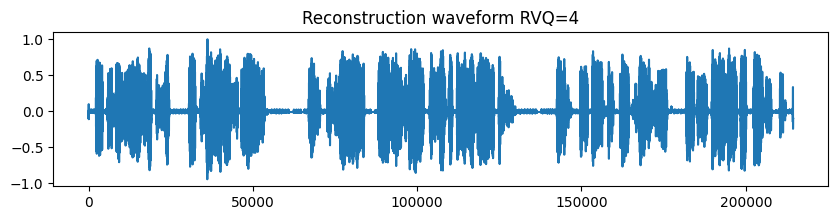

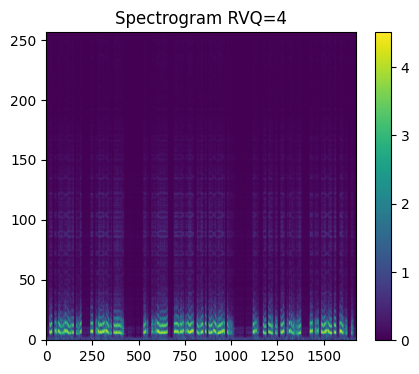

Saved: codec_rvq_4.wav
RVQ levels: 4 | Total tokens: 6700 | Bitrate: 4.50 kbps | Final STFT Loss: 0.3005
As RVQ levels increase, quality improves but tokens increase.

[RVQ=8] epoch=0, loss=0.3347
[RVQ=8] epoch=100, loss=0.2913
[RVQ=8] epoch=200, loss=0.2878
[RVQ=8] epoch=300, loss=0.2931
[RVQ=8] Early stopping at epoch 375


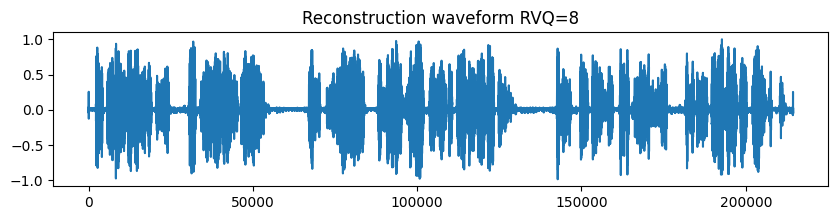

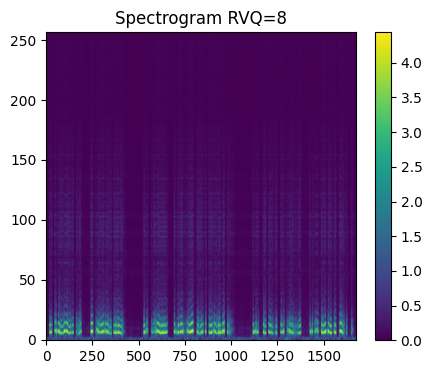

Saved: codec_rvq_8.wav
RVQ levels: 8 | Total tokens: 13400 | Bitrate: 9.00 kbps | Final STFT Loss: 0.3055
As RVQ levels increase, quality improves but tokens increase.

[RVQ=16] epoch=0, loss=0.3414
[RVQ=16] epoch=100, loss=0.3084
[RVQ=16] epoch=200, loss=0.3207
[RVQ=16] Early stopping at epoch 279


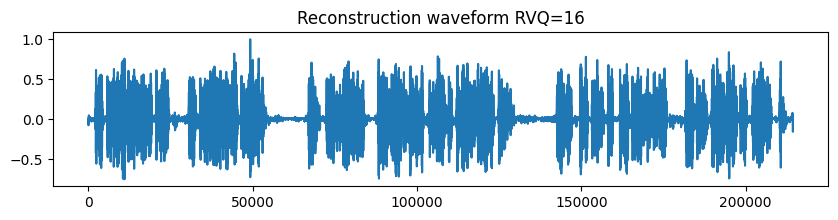

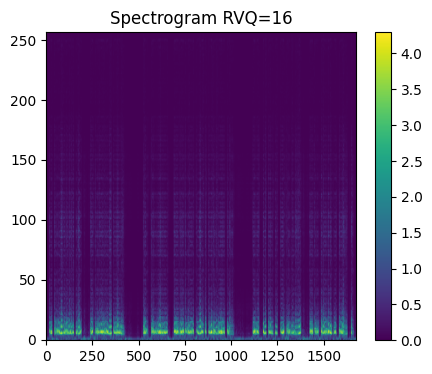

Saved: codec_rvq_16.wav
RVQ levels: 16 | Total tokens: 26800 | Bitrate: 18.00 kbps | Final STFT Loss: 0.3228
As RVQ levels increase, quality improves but tokens increase.


========== RVQ VARIANT SUMMARY ==========
 RVQ Levels  Final STFT Loss  Bitrate (kbps)  Total Tokens         WAV Path
          4         0.300546             4.5          6700  codec_rvq_4.wav
          8         0.305473             9.0         13400  codec_rvq_8.wav
         16         0.322792            18.0         26800 codec_rvq_16.wav


In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
latent_hz = target_sr // 128  # 125 Hz


class MultiScaleSTFTLoss(torch.nn.Module):

    def __init__(self, fft_sizes=(256, 512, 1024), hop_ratios=(0.25, 0.25, 0.25)):
        super().__init__()
        self.fft_sizes = fft_sizes
        self.hop_sizes = [int(f * h) for f, h in zip(fft_sizes, hop_ratios)]

    def stft_mag(self, x, fft_size, hop_size):
        # x: [B,1,T]
        x = x.squeeze(1)
        spec = torch.stft(
            x,
            n_fft=fft_size,
            hop_length=hop_size,
            win_length=fft_size,
            window=torch.hann_window(fft_size, device=x.device),
            return_complex=True
        )
        return spec.abs()

    def forward(self, y_hat, y):
        loss = 0.0
        for fft_size, hop_size in zip(self.fft_sizes, self.hop_sizes):
            mag_hat = self.stft_mag(y_hat, fft_size, hop_size)
            mag = self.stft_mag(y, fft_size, hop_size)

            min_TT = min(mag_hat.size(-1), mag.size(-1))
            mag_hat = mag_hat[..., :min_TT]
            mag = mag[..., :min_TT]

            loss += F.l1_loss(mag_hat, mag)

        return loss / len(self.fft_sizes)

def compute_bitrate(num_codebooks, codebook_size, latent_hz):
    bits_per_token = torch.log2(torch.tensor(codebook_size)).item()
    return num_codebooks * bits_per_token * latent_hz  # bits/sec

def train_rvq_variant(num_codebooks, max_epochs=5000, patience=200):
    encoder.to(device).train()
    decoder.to(device).train()
    rvq = RVQ(dim=64, num_codebooks=num_codebooks, codebook_size=512).to(device)

    params = list(encoder.parameters()) + list(decoder.parameters()) + list(rvq.parameters())
    optimizer = optim.Adam(params, lr=3e-4)
    loss_fn = MultiScaleSTFTLoss().to(device)

    best_loss = float("inf")
    no_improve = 0
    history = []

    for epoch in range(max_epochs):

        x_batch = get_batch(wav, batch_size).unsqueeze(1).to(device)  # [1,1,T]

        z = encoder(x_batch)         # [B, 64, T/128]
        q, tokens = rvq(z)           # [B,64,T/128], [B,T/128,num_codebooks]
        y_hat = decoder(q)           # [B,1,T]

        loss = loss_fn(y_hat, x_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        history.append(loss.item())

        if loss.item() < best_loss:
            best_loss = loss.item()
            no_improve = 0
        else:
            no_improve += 1

        if epoch % 100 == 0:
            print(f"[RVQ={num_codebooks}] epoch={epoch}, loss={loss.item():.4f}")

        if no_improve >= patience:
            print(f"[RVQ={num_codebooks}] Early stopping at epoch {epoch}")
            break

    encoder.eval()
    decoder.eval()
    rvq.eval()
    with torch.no_grad():
        x_eval = get_batch(wav, batch_size=1).unsqueeze(1).to(device)
        z = encoder(x_eval)
        q, tokens = rvq(z)
        y_hat = decoder(q)

    audio = y_hat.squeeze().cpu().numpy()
    audio = audio / (abs(audio).max() + 1e-8)
    out_path = f"codec_rvq_{num_codebooks}.wav"
    sf.write(out_path, audio, target_sr)


    final_loss = loss_fn(y_hat, x_eval).item()
    bitrate = compute_bitrate(num_codebooks, 512, latent_hz)
    total_tokens = tokens.numel()


    plt.figure(figsize=(10,2))
    plt.plot(audio)
    plt.title(f"Reconstruction waveform RVQ={num_codebooks}")
    plt.show()


    spec = torch.stft(
        torch.from_numpy(audio),
        n_fft=512,
        hop_length=128,
        win_length=512,
        window=torch.hann_window(512),
        return_complex=True
    ).abs()
    plt.figure(figsize=(5,4))
    plt.imshow(spec.log1p().numpy(), aspect="auto", origin="lower")
    plt.title(f"Spectrogram RVQ={num_codebooks}")
    plt.colorbar()
    plt.show()

    print(f"Saved: {out_path}")
    print(f"RVQ levels: {num_codebooks} | Total tokens: {total_tokens} | Bitrate: {bitrate/1000:.2f} kbps | Final STFT Loss: {final_loss:.4f}")
    print("As RVQ levels increase, quality improves but tokens increase.\n")

    return {
        "RVQ Levels": num_codebooks,
        "Final STFT Loss": final_loss,
        "Bitrate (kbps)": bitrate/1000,
        "Total Tokens": total_tokens,
        "WAV Path": out_path
    }

results_metrics = []
for levels in [4, 8, 16]:
    metrics = train_rvq_variant(levels)
    results_metrics.append(metrics)

df = pd.DataFrame(results_metrics)
print("\n========== RVQ VARIANT SUMMARY ==========")
print(df.to_string(index=False))
